In [2]:
from lstm_module import LSTM_SS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings

warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('C:/Users/shail/Desktop/project/raw data/Device-1.csv')

df.columns = ['SNo','temp','hum','co','no2','pm2_5','pm10','date']
date = df['date']
df = df.drop(["SNo"],axis=1)
df['date'] = pd.to_datetime(df['date'])
#df.index.freq='MS'

In [4]:
df = df[(df['co'] > 0) & (df['no2'] > 0) & (df['pm2_5'] > 0) & (df['pm10'] > 0)]

In [5]:
temp_one_hr = round(df.resample('60min',on='date').temp.mean(),2)
hum_one_hr = round(df.resample('60min',on='date').hum.mean(),2)
co_one_hr = round(df.resample('60min',on='date').co.mean(),2)
no2_one_hr = round(df.resample('60min',on='date').no2.mean(),2)
pm2_5_one_hr = round(df.resample('60min',on='date').pm2_5.mean(),2)
pm10_one_hr = round(df.resample('60min',on='date').pm10.mean(),2)

one_hr_sample = pd.DataFrame({
    "TEMP":temp_one_hr,
    "HUM":hum_one_hr,
    "CO":co_one_hr,
    "NO2":no2_one_hr,
    "PM2.5":pm2_5_one_hr,
    "PM10":pm10_one_hr
})

one_hr_sample

,TEMP,HUM,CO,NO2,PM2.5,PM10
date,,,,,,
2019-09-13 11:00:00,20.72,45.55,5.50,19.41,20.07,28.07
2019-09-13 12:00:00,21.68,45.55,5.22,19.42,21.99,30.39
2019-09-13 13:00:00,22.19,43.53,5.67,19.43,22.63,31.49
2019-09-13 14:00:00,21.73,44.27,4.93,19.42,24.61,34.45
2019-09-13 15:00:00,19.29,54.04,6.34,19.40,28.56,39.77
...,...,...,...,...,...,...
2020-01-11 13:00:00,17.92,44.29,40.00,1.38,66.62,92.64
2020-01-11 14:00:00,17.50,42.56,40.00,1.41,57.87,80.33
2020-01-11 15:00:00,16.74,44.00,40.00,1.45,53.99,74.98


In [6]:
pm = one_hr_sample[['PM2.5']].copy()

In [7]:
pm

,PM2.5
date,
2019-09-13 11:00:00,20.07
2019-09-13 12:00:00,21.99
2019-09-13 13:00:00,22.63
2019-09-13 14:00:00,24.61
2019-09-13 15:00:00,28.56
...,...
2020-01-11 13:00:00,66.62
2020-01-11 14:00:00,57.87
2020-01-11 15:00:00,53.99


In [8]:
df = pm.copy()

In [12]:
df.isna().sum()

PM2.5    0
dtype: int64

In [10]:
df = df.interpolate(method ='linear')

<AxesSubplot:xlabel='date'>

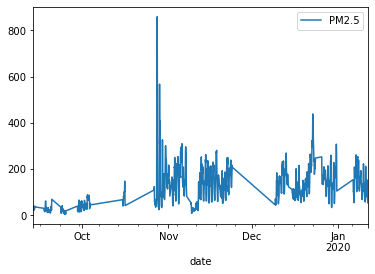

In [11]:
df.plot()

In [14]:
len(df)

2887

In [15]:
train = df.iloc[:2863]
test = df.iloc[2863:]

scaler = MinMaxScaler()

In [16]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

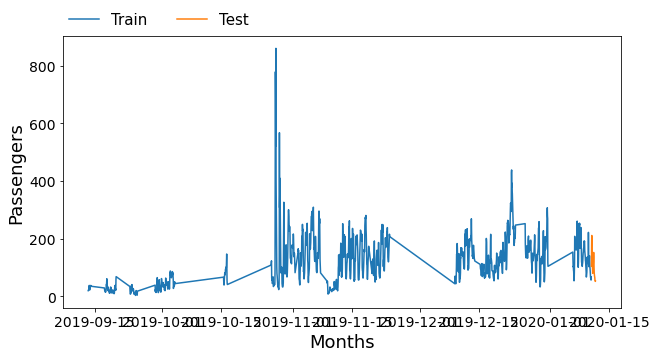

In [17]:
plt.figure(figsize=(10, 5))

plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')

plt.xlabel('Months', fontsize=18)
plt.ylabel('Passengers', fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=3, 
           borderaxespad=0, frameon=False, prop={"size":15})

plt.show()


In [18]:
n_input = 24
n_features = 1

def generate_data(data, n_input):
    X, y = [], []
    for i in range(0,len(data)-n_input):
            X.append(data[i:i+n_input])
            y.append(data[i+n_input])
    return np.array(X), np.array(y)

X, y = generate_data(scaled_train, n_input)

# Original LSTM

In [19]:
model = Sequential()
model.add(LSTM(200, input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               161600    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.fit(X, y, epochs=50, verbose=0)

In [21]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)
    
test_predictions

[array([0.08976078], dtype=float32),
 array([0.10252935], dtype=float32),
 array([0.11224042], dtype=float32),
 array([0.11868665], dtype=float32),
 array([0.12221894], dtype=float32),
 array([0.12376069], dtype=float32),
 array([0.12478963], dtype=float32),
 array([0.12635896], dtype=float32),
 array([0.12858231], dtype=float32),
 array([0.13207588], dtype=float32),
 array([0.13665137], dtype=float32),
 array([0.14113905], dtype=float32),
 array([0.14424427], dtype=float32),
 array([0.14503519], dtype=float32),
 array([0.1431323], dtype=float32),
 array([0.13886373], dtype=float32),
 array([0.13312335], dtype=float32),
 array([0.1269003], dtype=float32),
 array([0.12115507], dtype=float32),
 array([0.11668333], dtype=float32),
 array([0.11395895], dtype=float32),
 array([0.11304663], dtype=float32),
 array([0.11368038], dtype=float32),
 array([0.11538145], dtype=float32)]

In [22]:
true_predictions = scaler.inverse_transform(test_predictions)

test['original_LSTM'] = true_predictions

<AxesSubplot:xlabel='date'>

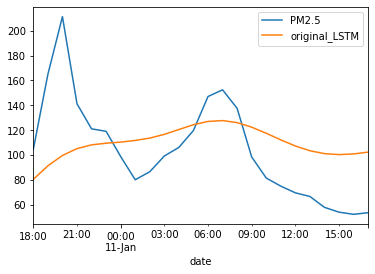

In [23]:
test.plot()

In [24]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['original_LSTM']))
print(rmse)

39.98990013826455


In [25]:
test

,PM2.5,original_LSTM
date,,
2020-01-10 18:00:00,104.55,80.379716
2020-01-10 19:00:00,164.92,91.310247
2020-01-10 20:00:00,211.35,99.623411
2020-01-10 21:00:00,141.20,105.141703
2020-01-10 22:00:00,121.06,108.165521
2020-01-10 23:00:00,119.04,109.485335
2020-01-11 00:00:00,98.77,110.366159
2020-01-11 01:00:00,80.07,111.709584
2020-01-11 02:00:00,86.52,113.612890


# SELF_MADE_LSTM

In [26]:
self_model = LSTM_SS(1, 1, 200, n_input, 0.01)

In [27]:
self_model.fit(50, X, y, verbose=False)

In [28]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    current_pred = self_model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)
    
test_predictions

[array([0.11162306]),
 array([0.07231776]),
 array([0.10575556]),
 array([0.15127708]),
 array([0.07314513]),
 array([0.07279567]),
 array([0.07315354]),
 array([0.12900397]),
 array([0.07975131]),
 array([0.08389246]),
 array([0.09109182]),
 array([0.10276571]),
 array([0.13076784]),
 array([0.13060773]),
 array([0.0589814]),
 array([0.05611496]),
 array([0.13416693]),
 array([0.08046954]),
 array([0.11714526]),
 array([0.0780918]),
 array([0.12115533]),
 array([0.07883979]),
 array([0.07030206]),
 array([0.06245595])]

In [29]:
true_predictions = scaler.inverse_transform(test_predictions)

test['SELF_MADE_LSTM'] = true_predictions

<AxesSubplot:xlabel='date'>

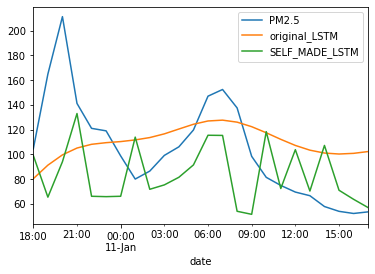

In [30]:
test.plot()

In [31]:
rmse = sqrt(mean_squared_error(test['PM2.5'], test['SELF_MADE_LSTM']))
print(rmse)

46.083554114221926


In [32]:
test

,PM2.5,original_LSTM,SELF_MADE_LSTM
date,,,
2020-01-10 18:00:00,104.55,80.379716,99.094916
2020-01-10 19:00:00,164.92,91.310247,65.447617
2020-01-10 20:00:00,211.35,99.623411,94.072044
2020-01-10 21:00:00,141.20,105.141703,133.040747
2020-01-10 22:00:00,121.06,108.165521,66.155892
2020-01-10 23:00:00,119.04,109.485335,65.856731
2020-01-11 00:00:00,98.77,110.366159,66.163088
2020-01-11 01:00:00,80.07,111.709584,113.973851
2020-01-11 02:00:00,86.52,113.612890,71.811112
